In [8]:
import bioread
import pandas as pd
acq_file = bioread.read_file(r'C:\Users\User\Desktop\TIM.acq')

channels_to_extract = ['Heart Rate', 'ECG - ECG100C', 'C5 - Expression' ]
data = {}
for channel_name in channels_to_extract:
    channel = acq_file.named_channels[channel_name]
    data[channel_name] = channel.data

df = pd.DataFrame(data)
df.head()

,Heart Rate,ECG - ECG100C,C5 - Expression
0,0.0,0.118256,0.0
1,0.0,0.119476,0.0
2,0.0,0.119934,0.0
3,0.0,0.121307,0.0
4,0.0,0.121460,0.0


In [9]:
acq_file.channels

[Channel EDA - EDA100C: 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel ECG - ECG100C: 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel EMG - EMG100C: 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Stim current - CBLCFMA - Current Feedba: 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 0): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 1): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 2): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 3): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 4): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 5): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 6): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel Digital (STP Input 7): 7904435 samples, 2000.0 samples/sec, loaded: True,
 Channel H

In [14]:
import heartpy as hp

C:\Users\User\PycharmProjects\Neuroscience-of-Anxiety-Lab\venv\lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


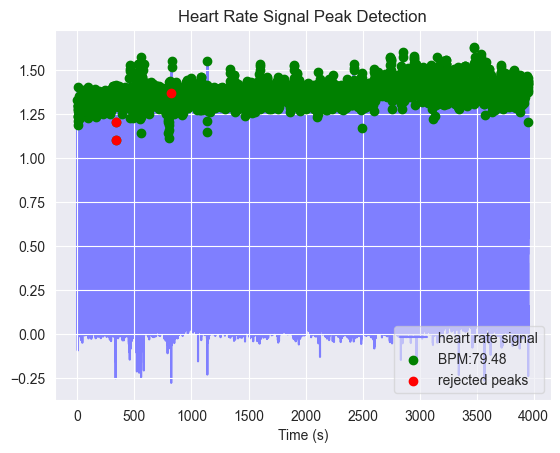

In [22]:
hr_data = df['Heart Rate'].values
ecg_data = df['ECG - ECG100C'].values
events_data = df['C5 - Expression'].values
ecg_sampling_rate = 2000

# we can add more filters to the process function. 
# The ecg_working_data contains filters  ECG signal without noise and artifacts, and then detects R-peaks.
# The ecg_measures dictionary contains various heart rate measures and statistics calculated from the processed ECG data.
# statics like mean, max, min
ecg_working_data, ecg_measures = hp.process(ecg_data, ecg_sampling_rate)
hp.plotter(ecg_working_data, ecg_measures)
# cleaning the heart rate data- needs to ask what are the values we are looking for
min_hr = 0
max_hr = 0
for hr in hr_data:
    if hr >= min_hr and hr <= max_hr:
        cleaned_hr_data = hr_data - hr
# after cleaning the data I can analyze - needs to ask what, and find correlations between the ecg, heart rate and other parameters






    